In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install ultralytics
from ultralytics import YOLO

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 914.9/914.9 kB 45.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 64.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 35.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 76.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [ ]:
import pandas as pd
import os

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Endoscope Detection/Yolov11/gastroscopy_meta_256.csv")

In [ ]:
df.head()

,image_id,height,width,organ,lesion_label,location,shape_type_polygon,polygon_mask,bounding_box_shape,x_min,y_min,x_max,y_max,lesion
0,1_1_00011.png,256.0,256.0,gastroscopy,0,1,polygon,"1257.45,738.30;1212.77,748.94;1168.09,748.94;1...",rectangle,95.478723,45.744681,163.031915,93.617021,ulcer
1,1_1_00011.png,256.0,256.0,gastroscopy,0,1,polygon,"1421.28,955.32;1387.23,985.11;1368.09,1025.53;...",rectangle,143.617021,112.234043,177.659574,135.372340,ulcer
2,1_1_00014.png,256.0,256.0,gastroscopy,0,1,polygon,"1065.96,1110.64;1040.43,1148.94;1010.64,1182.9...",rectangle,65.159574,70.212766,134.840426,153.191489,ulcer
3,1_1_00017.png,256.0,256.0,gastroscopy,0,1,polygon,"1246.30,514.89;1197.36,508.51;1154.81,502.13;1...",rectangle,110.574468,62.765957,172.010638,94.148936,ulcer
4,1_1_00018.png,256.0,256.0,gastroscopy,0,1,polygon,"1397.36,389.36;1352.68,382.98;1314.38,404.26;1...",rectangle,145.148936,47.872340,206.851064,134.308511,ulcer


In [ ]:
from sklearn.model_selection import StratifiedKFold
df['label'] = df['image_id'].apply(lambda x: int(x.split('_')[1]))

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for train_index, val_index in skf.split(df, df['label']):
    train_df = df.iloc[train_index]
    val_df = df.iloc[val_index]

train_df.to_csv('train.csv', index=False)
val_df.to_csv('val.csv', index=False)

In [ ]:
label_df = pd.read_csv('/content/drive/MyDrive/Endoscope Detection/Yolov11/val.csv')
image_folder = r'/content/drive/MyDrive/Endoscope Detection/Yolov11/Dataset/images/val'
label_folder = r'/content/drive/MyDrive/Endoscope Detection/Yolov11/Dataset/labels/val'

os.makedirs(label_folder, exist_ok=True)

for img_id in label_df['image_id']:
    img_file_path = os.path.join(image_folder, img_id)

    if os.path.exists(img_file_path):
        group = df[df['image_id'] == img_id]

        label_file_path = os.path.join(label_folder, f'{img_id.replace(".png", ".txt")}')

        with open(label_file_path, 'w') as label_file:
            for _, row in group.iterrows():
                obj_class = row['lesion_label']

                x_min, y_min, x_max, y_max = row['x_min'], row['y_min'], row['x_max'], row['y_max']
                img_width, img_height = row['width'], row['height']

                x_center = (x_min + x_max) / 2 / img_width
                y_center = (y_min + y_max) / 2 / img_height
                width = (x_max - x_min) / img_width
                height = (y_max - y_min) / img_height

                label_file.write(f'{obj_class} {x_center} {y_center} {width} {height}\n')

In [ ]:
!yolo predict model=yolo11n.pt source='https://ultralytics.com/images/zidane.jpg'

100% 5.35M/5.35M [00:00<00:00, 60.3MB/s]
Ultralytics 8.3.67 🚀 Python-3.11.11 torch-2.5.1+cu121 CPU (Intel Xeon 2.20GHz)
YOLO11n summary (fused): 238 layers, 2,616,248 parameters, 0 gradients, 6.5 GFLOPs

100% 49.2k/49.2k [00:00<00:00, 3.58MB/s]
image 1/1 /content/zidane.jpg: 384x640 2 persons, 1 tie, 178.2ms
Speed: 24.1ms preprocess, 178.2ms inference, 40.0ms postprocess per image at shape (1, 3, 384, 640)
Results saved to runs/detect/predict
💡 Learn more at https://docs.ultralytics.com/modes/predict


In [ ]:
from ultralytics.data.augment import Albumentations

def disable_albumentations(self, p=0.0):
    self.p = 0.0
    self.transform = None

Albumentations.__init__ = disable_albumentations

In [ ]:
from ultralytics import YOLO
model = YOLO("yolo11n.pt")

results = model.train(data="/content/drive/MyDrive/Endoscope Detection/Yolov11/Dataset/data.yaml",
                      project="/content/drive/MyDrive/Endoscope Detection/Yolov11/experiment/v1",
                      name="exp1",
                      epochs=50,
                      imgsz=256,
                      hsv_h=0.0,
                      hsv_s=0.0,
                      hsv_v=0.0,
                      degrees=0.0,
                      translate=0.0,
                      scale=0.0,
                      shear=0.0,
                      perspective=0.0,
                      flipud=0.0,
                      fliplr=0.0,
                      mosaic=0.0,
                      mixup=0.0,
                      auto_augment="none",
                      erasing=0.0,
                      copy_paste=0.0
                      )


Ultralytics 8.3.70 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolo11n.pt, data=/content/drive/MyDrive/Endoscope Detection/Yolov11/Dataset/data.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=256, save=True, save_period=-1, cache=False, device=None, workers=8, project=/content/drive/MyDrive/Endoscope Detection/Yolov11/experiment/v1, name=exp1, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=

train: Scanning /content/drive/MyDrive/Endoscope Detection/Yolov11/Dataset/labels/train.cache... 1280 images, 1 backgrounds, 0 corrupt: 100%|██████████| 1280/1280 [00:00<?, ?it/s]

train: WARNING ⚠️ /content/drive/MyDrive/Endoscope Detection/Yolov11/Dataset/images/train/1_1_00024.png: 2 duplicate labels removed
train: WARNING ⚠️ /content/drive/MyDrive/Endoscope Detection/Yolov11/Dataset/images/train/1_1_00027.png: 1 duplicate labels removed



val: Scanning /content/drive/MyDrive/Endoscope Detection/Yolov11/Dataset/labels/val.cache... 320 images, 0 backgrounds, 0 corrupt: 100%|██████████| 320/320 [00:00<?, ?it/s]


Plotting labels to /content/drive/MyDrive/Endoscope Detection/Yolov11/experiment/v1/exp1/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 256 train, 256 val
Using 2 dataloader workers
Logging results to /content/drive/MyDrive/Endoscope Detection/Yolov11/experiment/v1/exp1
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50     0.598G      1.522      2.912      1.443         21        256: 100%|██████████| 80/80 [00:20<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.06it/s]

                   all        320        450      0.349      0.242      0.189     0.0835



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50     0.564G      1.533       2.21      1.436         21        256: 100%|██████████| 80/80 [00:20<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.00it/s]

                   all        320        450      0.286      0.352       0.23     0.0934



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      0.56G       1.46      1.945      1.374         18        256: 100%|██████████| 80/80 [00:20<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.50it/s]

                   all        320        450      0.368      0.368      0.276      0.119



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50     0.581G      1.393      1.805      1.342         22        256: 100%|██████████| 80/80 [00:19<00:00,  4.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.20it/s]


                   all        320        450        0.5      0.407      0.374      0.173

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      0.56G      1.261      1.595      1.241         19        256: 100%|██████████| 80/80 [00:19<00:00,  4.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]

                   all        320        450      0.464      0.377      0.379      0.172



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50     0.558G      1.184      1.451      1.196         26        256: 100%|██████████| 80/80 [00:18<00:00,  4.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.78it/s]

                   all        320        450      0.547      0.427      0.409      0.179



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50     0.581G      1.101      1.246      1.132         24        256: 100%|██████████| 80/80 [00:18<00:00,  4.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.94it/s]

                   all        320        450      0.532      0.466       0.45      0.217



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50     0.579G      1.014      1.116      1.085         24        256: 100%|██████████| 80/80 [00:18<00:00,  4.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.36it/s]

                   all        320        450      0.437        0.5      0.445      0.213



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50     0.579G     0.9515     0.9927      1.044         35        256: 100%|██████████| 80/80 [00:18<00:00,  4.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.30it/s]

                   all        320        450      0.511      0.419      0.381      0.166



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50     0.579G     0.8871     0.9255       1.01         21        256: 100%|██████████| 80/80 [00:18<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.69it/s]

                   all        320        450      0.482      0.489      0.454      0.205



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50     0.579G      0.832     0.8433     0.9767         26        256: 100%|██████████| 80/80 [00:18<00:00,  4.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.93it/s]

                   all        320        450      0.484      0.421      0.376       0.18



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50     0.579G     0.7592      0.744     0.9401         23        256: 100%|██████████| 80/80 [00:18<00:00,  4.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.97it/s]

                   all        320        450      0.545      0.483      0.447      0.232



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50     0.579G     0.7263     0.6899      0.921         17        256: 100%|██████████| 80/80 [00:18<00:00,  4.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.22it/s]

                   all        320        450      0.551      0.454      0.445      0.211



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50     0.579G     0.6898     0.6412     0.9018         22        256: 100%|██████████| 80/80 [00:18<00:00,  4.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.42it/s]

                   all        320        450       0.57      0.486      0.481      0.239



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50     0.558G     0.6364     0.5861     0.8786         22        256: 100%|██████████| 80/80 [00:18<00:00,  4.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.97it/s]

                   all        320        450      0.611      0.437      0.452      0.234



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50     0.579G     0.6034     0.5444     0.8611         20        256: 100%|██████████| 80/80 [00:18<00:00,  4.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.71it/s]

                   all        320        450      0.521      0.483       0.45      0.225



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50     0.579G     0.5842     0.5323     0.8547         23        256: 100%|██████████| 80/80 [00:18<00:00,  4.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]

                   all        320        450      0.544      0.505      0.489      0.254



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50     0.579G     0.5416     0.5008     0.8386         17        256: 100%|██████████| 80/80 [00:18<00:00,  4.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.01it/s]

                   all        320        450      0.489      0.496      0.462       0.24



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50     0.558G     0.5088     0.4574     0.8285         16        256: 100%|██████████| 80/80 [00:18<00:00,  4.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.49it/s]

                   all        320        450      0.547      0.471      0.459      0.217



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50     0.558G     0.4947     0.4344     0.8205         29        256: 100%|██████████| 80/80 [00:18<00:00,  4.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.04it/s]

                   all        320        450      0.501      0.479      0.446      0.222



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50     0.579G     0.4626     0.4067     0.8104         25        256: 100%|██████████| 80/80 [00:18<00:00,  4.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.94it/s]

                   all        320        450      0.533      0.513      0.497      0.241



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50     0.558G     0.4506     0.3886     0.8061         37        256: 100%|██████████| 80/80 [00:18<00:00,  4.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.69it/s]

                   all        320        450      0.536       0.47       0.47      0.228



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50     0.579G     0.4204     0.3762      0.796         26        256: 100%|██████████| 80/80 [00:18<00:00,  4.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.45it/s]

                   all        320        450      0.563      0.393      0.435      0.217



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50     0.558G     0.3988      0.352     0.7905         25        256: 100%|██████████| 80/80 [00:18<00:00,  4.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.16it/s]

                   all        320        450       0.56      0.441      0.436      0.219



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50     0.579G     0.3839     0.3344     0.7848         21        256: 100%|██████████| 80/80 [00:18<00:00,  4.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.10it/s]

                   all        320        450      0.609      0.466      0.513      0.255



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50     0.579G     0.3644     0.3213     0.7798         19        256: 100%|██████████| 80/80 [00:18<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.07it/s]

                   all        320        450      0.582      0.475      0.497      0.247



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50     0.579G     0.3424     0.2964     0.7755         22        256: 100%|██████████| 80/80 [00:18<00:00,  4.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.95it/s]

                   all        320        450      0.612      0.446      0.495       0.24



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50     0.579G     0.3264     0.2816     0.7715         22        256: 100%|██████████| 80/80 [00:18<00:00,  4.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.83it/s]

                   all        320        450      0.559      0.463      0.488      0.244



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50     0.558G     0.3145     0.2767     0.7686         22        256: 100%|██████████| 80/80 [00:18<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.95it/s]

                   all        320        450      0.624      0.445       0.51      0.262



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50     0.579G     0.2925      0.263     0.7631         26        256: 100%|██████████| 80/80 [00:18<00:00,  4.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.84it/s]

                   all        320        450      0.643      0.465      0.522      0.258



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50     0.558G     0.2806      0.252     0.7615         18        256: 100%|██████████| 80/80 [00:18<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.91it/s]

                   all        320        450       0.67      0.432      0.516       0.27



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50     0.558G      0.267     0.2415     0.7586         19        256: 100%|██████████| 80/80 [00:17<00:00,  4.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.85it/s]

                   all        320        450      0.559      0.489      0.511      0.261



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50     0.579G     0.2579     0.2316     0.7565         28        256: 100%|██████████| 80/80 [00:18<00:00,  4.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.03it/s]

                   all        320        450      0.624      0.448      0.507      0.261



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50     0.558G     0.2439     0.2217     0.7557         23        256: 100%|██████████| 80/80 [00:18<00:00,  4.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.00it/s]

                   all        320        450      0.616      0.487      0.526      0.266



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50     0.579G     0.2322     0.2145     0.7531         23        256: 100%|██████████| 80/80 [00:18<00:00,  4.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.82it/s]

                   all        320        450      0.542      0.454      0.472       0.24



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50     0.579G     0.2212     0.2036     0.7519         18        256: 100%|██████████| 80/80 [00:17<00:00,  4.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.04it/s]

                   all        320        450      0.498      0.418       0.39      0.201



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50     0.558G     0.2102     0.1958     0.7504         22        256: 100%|██████████| 80/80 [00:18<00:00,  4.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.99it/s]

                   all        320        450      0.532      0.444      0.456      0.236



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50     0.558G      0.196     0.1849     0.7467         24        256: 100%|██████████| 80/80 [00:18<00:00,  4.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.13it/s]

                   all        320        450      0.578      0.441      0.482      0.248



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50     0.579G     0.1854     0.1773     0.7462         21        256: 100%|██████████| 80/80 [00:18<00:00,  4.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.31it/s]


                   all        320        450      0.556      0.452      0.473      0.252

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50     0.579G     0.1792     0.1689      0.746         21        256: 100%|██████████| 80/80 [00:18<00:00,  4.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.50it/s]

                   all        320        450      0.557      0.462      0.483      0.253


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50     0.579G     0.1669     0.1633     0.7452         19        256: 100%|██████████| 80/80 [00:19<00:00,  4.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.58it/s]

                   all        320        450      0.567      0.455      0.493      0.255



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50     0.558G     0.1568     0.1552     0.7438         29        256: 100%|██████████| 80/80 [00:18<00:00,  4.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.87it/s]

                   all        320        450      0.588      0.432      0.481      0.246



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50     0.579G     0.1523     0.1512     0.7437         24        256: 100%|██████████| 80/80 [00:18<00:00,  4.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.12it/s]

                   all        320        450      0.555       0.45      0.486      0.253



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50     0.579G     0.1444     0.1457     0.7426         19        256: 100%|██████████| 80/80 [00:18<00:00,  4.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.26it/s]

                   all        320        450      0.511      0.474      0.472      0.245



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50     0.558G      0.138     0.1413     0.7422         19        256: 100%|██████████| 80/80 [00:18<00:00,  4.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.91it/s]

                   all        320        450      0.571      0.432      0.476      0.246



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50     0.558G     0.1272     0.1341     0.7411         20        256: 100%|██████████| 80/80 [00:18<00:00,  4.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.19it/s]

                   all        320        450      0.572      0.455      0.497      0.255



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50     0.579G     0.1231     0.1295     0.7412         26        256: 100%|██████████| 80/80 [00:18<00:00,  4.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.96it/s]

                   all        320        450       0.56       0.45      0.493      0.254



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50     0.556G     0.1137     0.1236       0.74         25        256: 100%|██████████| 80/80 [00:18<00:00,  4.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.95it/s]

                   all        320        450      0.575      0.454      0.488      0.255



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50     0.558G     0.1094     0.1213     0.7402         20        256: 100%|██████████| 80/80 [00:18<00:00,  4.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.47it/s]

                   all        320        450      0.573      0.442      0.488      0.254



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50     0.579G     0.1025      0.116     0.7397         26        256: 100%|██████████| 80/80 [00:18<00:00,  4.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.11it/s]

                   all        320        450      0.574      0.437      0.495      0.259



50 epochs completed in 0.323 hours.
Optimizer stripped from /content/drive/MyDrive/Endoscope Detection/Yolov11/experiment/v1/exp1/weights/last.pt, 5.4MB
Optimizer stripped from /content/drive/MyDrive/Endoscope Detection/Yolov11/experiment/v1/exp1/weights/best.pt, 5.4MB

Validating /content/drive/MyDrive/Endoscope Detection/Yolov11/experiment/v1/exp1/weights/best.pt...
Ultralytics 8.3.70 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 238 layers, 2,582,737 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.43it/s]


                   all        320        450      0.666      0.432      0.516       0.27
                 ulcer         80        108      0.451      0.426      0.356      0.164
                 polyp         80        148      0.887      0.479      0.639      0.339
                cancer        160        194       0.66      0.392      0.554      0.307
Speed: 0.1ms preprocess, 1.0ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to /content/drive/MyDrive/Endoscope Detection/Yolov11/experiment/v1/exp1


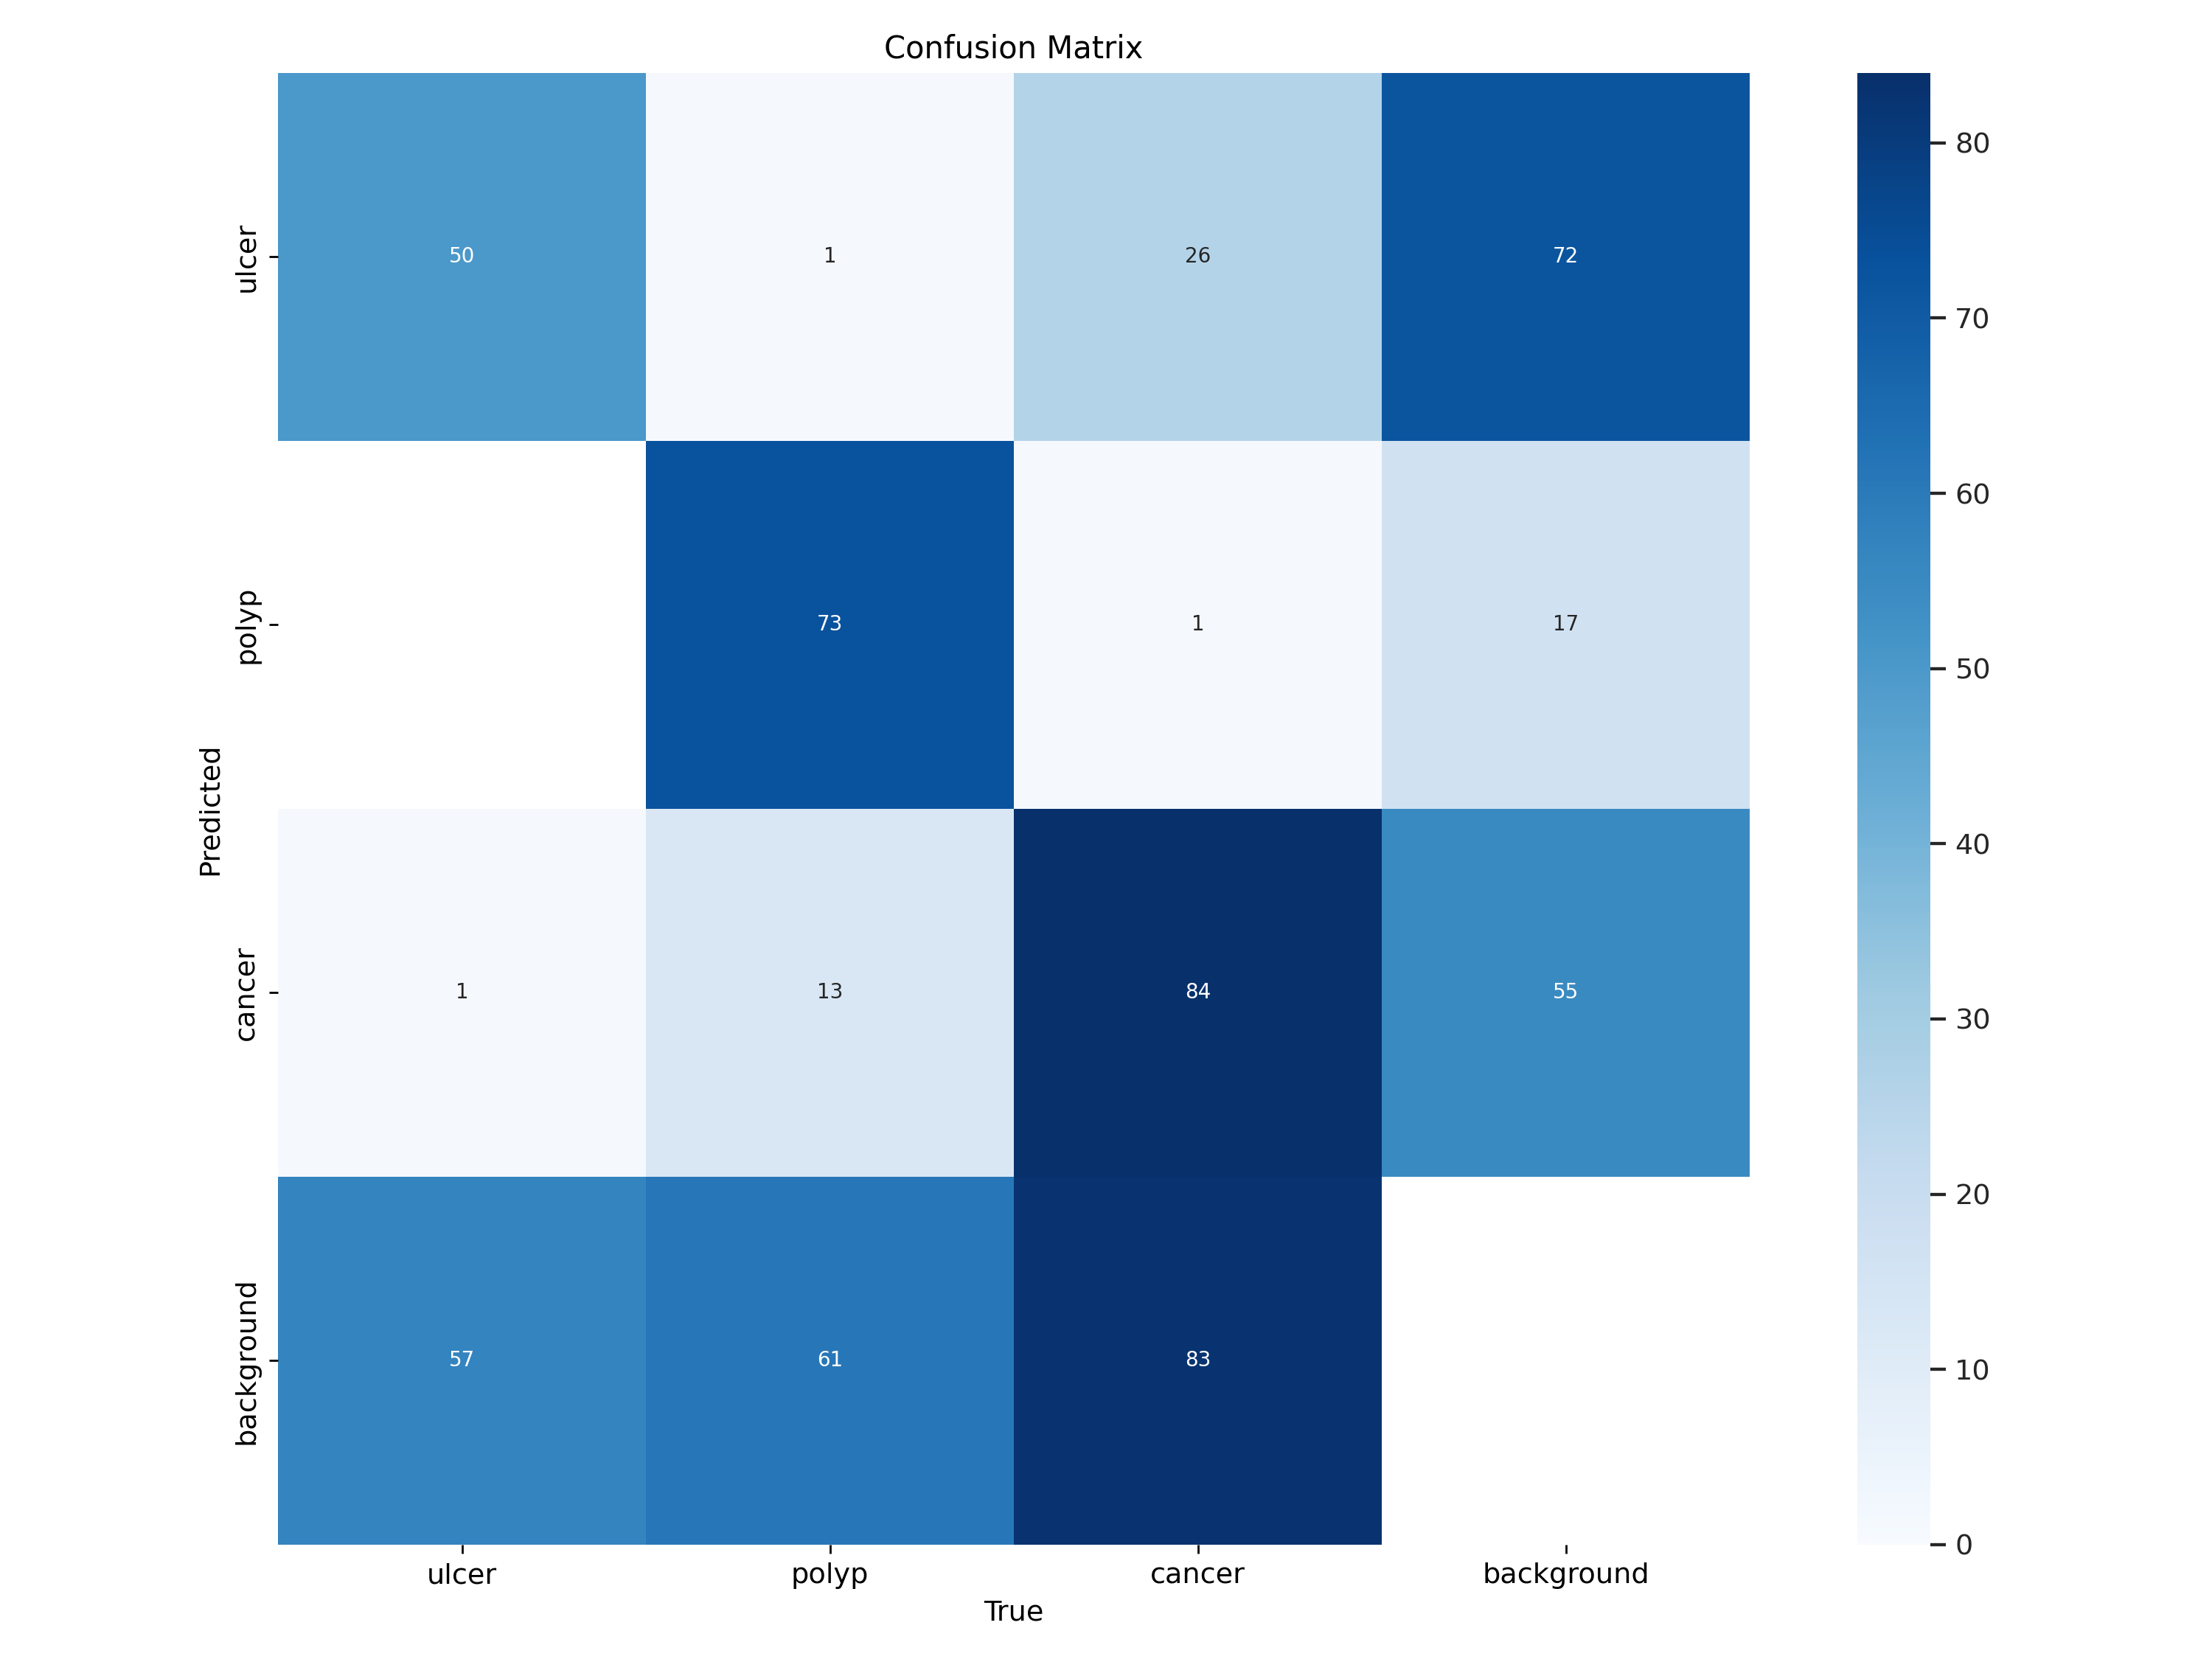

In [ ]:
from PIL import Image
Image.open('/content/drive/MyDrive/Endoscope Detection/Yolov11/experiment/v1/exp1/confusion_matrix.png')